# Simulation Demonstration

This notebook demonstrates the construction of a control system using the node based model, and the simulation of the system.

In [1]:
#importing the simulation, filterer, controller and agent classes
import sys
import math
import sympy
sys.path.append('../')
from humancompatible.interconnect.simulators.simulation import Simulation
from humancompatible.interconnect.simulators.filterer import Filterer
from humancompatible.interconnect.simulators.controller import Controller
from humancompatible.interconnect.simulators.agent import Agent
from humancompatible.interconnect.simulators.aggregator import Aggregator
from humancompatible.interconnect.simulators.reference import ReferenceSignal
from humancompatible.interconnect.simulators.delay import Delay
from humancompatible.interconnect.simulators.population import Population

## Reference Signal Node

In [2]:
refSig = ReferenceSignal(name="r")
refSig.set_reference_signal(0.5)

## Aggregator Node

Aggregator nodes are the only node that can accept a many to one connection. They will combine these signals into a single signal.

Logic is controlled by a logic class. For the aggregator node, this requires the following:
- `self.constants`: a dictionary of constants that are used in the logic
- `self.aggregation_function`: a function that takes in a list of signals and returns a single signal, where `args` is a list of signals


In [3]:
class AggregatorLogic:
    def __init__(self):
        self.constants = {}
        
    def aggregation_function(self, signalList):
        #takes a list of values, and needs to return a single summary value
        return sum(signalList)

agg1 = Aggregator(name="A1", logic=AggregatorLogic())
agg2 = Aggregator(name="A2", logic=AggregatorLogic())

## Controller Node

Controller nodes take a logic  object. For the controller, this requires the following:

- `self.symbols`: a dictionary of symbols that are used in the logic, uses the `sympy` library
- `self.constants`: a dictionary of constants that are used in the logic
- `self.variables`: a list of variables that are used in the logic, in the order that they are passed to the node
- `self.expression`: a sympy expression that is used to calculate the output signal

In [4]:
class ControllerLogic():
    def __init__(self):
        self.symbols = {"S":sympy.Symbol("S"),
                        "K":sympy.Symbol("K")}
        self.constants = {"K":2}
        self.variables = ["S"]
        self.expression = (self.symbols["S"]+1)/self.symbols["K"]

cont = Controller(name="C", logic=ControllerLogic())

## Population Node

A node that represents a population of agents. Takes a logic object, along with a number of agents and the positive and negative feedback signals. This logic will be applied to each agent in the population. In order to use multiple types of agents, multiple population nodes can be used in parallel, and joined with an aggregator node.

In [18]:
class AgentLogic:
    def __init__(self):
        x, startThreshold, endThreshold = sympy.symbols('x startThreshold endThreshold')
        self.symbols = {"x": x, "startThreshold": startThreshold, "endThreshold": endThreshold}
        self.constants = {"startThreshold": -80, "endThreshold": 20}
        self.variables = ["x"]
        self.expression = sympy.Piecewise(
            (0, self.symbols["x"] < self.symbols["startThreshold"]),
            (1, self.symbols["x"] > self.symbols["endThreshold"]),
            ((1 + sympy.cos(sympy.pi * (self.symbols["x"] - self.symbols["endThreshold"]) / (self.symbols["startThreshold"] - self.symbols["endThreshold"]))) / 2, True)
        )

pop = Population(name="P", 
                logic=AgentLogic(), 
                number_of_agents=100000, 
                positive_response=1, 
                negative_response=0)

The `plot_probability` function is used to plot the probability of the agents being in each state, used for debugging. A `xMin` and `xMax` value can be passed to set the range of the x axis, otherwise it will be automatically according to the data.

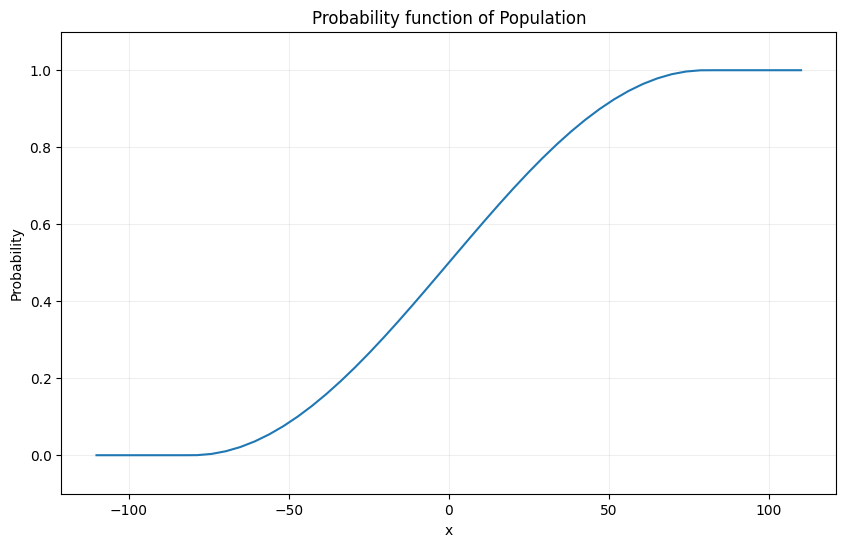

In [19]:
pop.plot_probability()

## Delay Node

In [7]:
delay = Delay(name="Z", time=1)

## Filterer Node

Filterer nodes take a logic  object. For the controller, this requires the following:

- `self.symbols`: a dictionary of symbols that are used in the logic, uses the `sympy` library
- `self.constants`: a dictionary of constants that are used in the logic
- `self.variables`: a list of variables that are used in the logic, in the order that they are passed to the node
- `self.expression`: a sympy expression that is used to calculate the output signal

In [8]:
class filtererLogic():
    def __init__(self):
        self.symbols = {"S":sympy.Symbol("S"),
                        "K":sympy.Symbol("K")}
        self.constants = {"K":2}
        self.variables = ["S"]
        self.expression = (self.symbols["S"]+1)/self.symbols["K"]

fil = Filterer(name="F", logic=filtererLogic())

## Simulation

In [9]:
sim = Simulation()

### Creating the system

The system is composed of a number of nodes.

Single nodes can be added using the `system.add_node` method. Multiple nodes can be added using the `system.add_nodes` method, where a list of nodes is passed as an argument.

To connect nodes, the `system.connect` method is used. This method takes two arguments, the first being the source node and the second being the target node.

The start node, where the process begins, and the checkpoint node, where an iteration is considered complete, are added using the `system.add_start` and `system.add_checkpoint` methods, respectively.

In [10]:
sim.system.add_nodes([refSig, agg1, cont,pop, agg2, delay, fil])
sim.system.connect_nodes(refSig, agg1)
sim.system.connect_nodes(agg1, cont)
sim.system.connect_nodes(cont, pop)
sim.system.connect_nodes(pop, agg2)
sim.system.connect_nodes(agg2, delay)
sim.system.connect_nodes(delay, fil)
sim.system.connect_nodes(fil, agg1)

sim.system.set_start_node(refSig)
sim.system.set_checkpoint_node(agg1)

### Rendering the system graph

Calling the `system.render_graph()` method will produce a visualisation of the control system. This is useful for ensuring that the system has been constructed according to the desired configuration.

The start node, shaded in green, indicates where the process will begin.

The checkpoint node, shaded in blue, indicates where the iteration count will be incremented. Typically, this will be the first node in the circular path of the system.

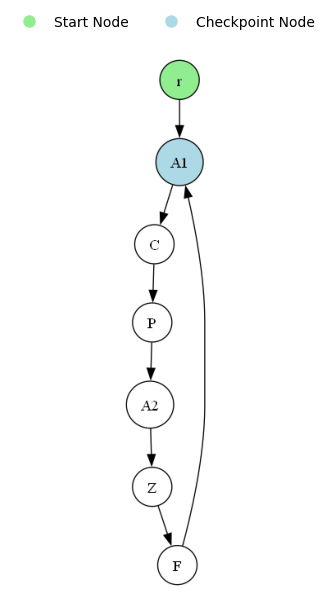

In [11]:
sim.system.render_graph()

### Checking the validity of the system

This is automatically done prior to running the simulation, but it can be done manually by calling the `check_system` method.

In [12]:
validSystem = sim.system.check_system()
if validSystem:
    print("System is valid")
else:
    for e in validSystem:
        print(e)

System is valid


### Running the simulation

In [13]:
sim.system.run(100, showTrace=False)

Running Control System:   0%|          | 0/100 [00:00<?, ?it/s]

Running Control System: 101it [00:00, 205.24it/s]                        


### Plotting Node History

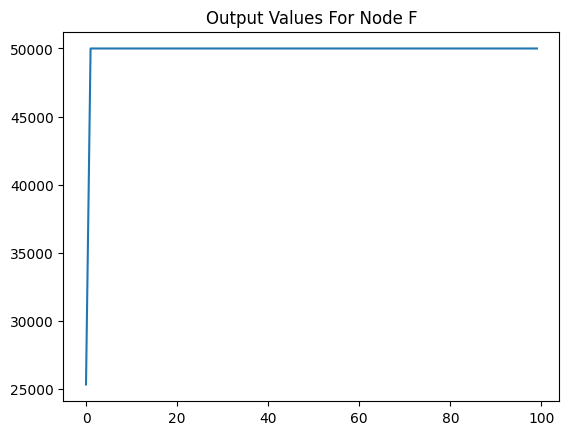

In [14]:
sim.system.plotNodeOutputHistory(fil)

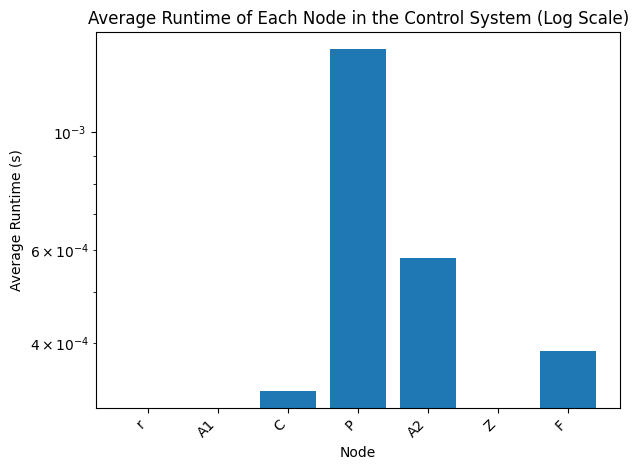

In [15]:
sim.system.plotRuntimes()